<a href="https://colab.research.google.com/github/makoto199247/book-decision-analysis-and-forecast/blob/main/animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# kaggleのjsonファイルを設定
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
import kaggle

# データセットをダウンロード
kaggle.api.authenticate()
kaggle.api.dataset_download_files('antoreepjana/animals-detection-images-dataset', path='./', unzip=True)

In [17]:
import os
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# 入っているデータセットの中身を確認する

In [18]:
data_dir = './'
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

all_train_subdir = glob.glob(train_dir + "/*")
all_test_subdir = glob.glob(test_dir + "/*")

train_classes = [os.path.basename(pp) for pp in all_train_subdir]
test_classes = [os.path.basename(pp) for pp in all_test_subdir]

# print(len(train_classes))
# print(len(test_classes))

train_image_counts = {os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_train_subdir}
test_image_counts = {os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_test_subdir}
train_data_df = pd.DataFrame(train_image_counts, index=["train"])
test_data_df = pd.DataFrame(test_image_counts, index=["test"])
all_data_df = pd.concat([train_data_df, test_data_df]).transpose()
print(all_data_df)

           train  test
Worm         128    15
Whale        287    52
Elephant     155    33
Seahorse       7    33
Sea lion     188    48
...          ...   ...
Deer         327   177
Owl          406    70
Shark        303    58
Jellyfish    457    92
Koala         56    24

[80 rows x 2 columns]


今回はデータセットが80あるが、課題は21クラスに分類。 \
trainデータが多いもの（学習精度が高くなりやすいもの）に絞って学習を行う方針でいきたい

In [19]:
# 学習データ量が多い順にソート
sorted_train_data_df = train_data_df.sort_values(by="train", axis=1, ascending=False)

# 上位21種類の動物を抽出
selected_classes = sorted_train_data_df.columns[:21].tolist()

print("Selected classes:", selected_classes)

Selected classes: ['Butterfly', 'Moths and butterflies', 'Lizard', 'Spider', 'Fish', 'Monkey', 'Eagle', 'Frog', 'Snake', 'Duck', 'Caterpillar', 'Sparrow', 'Jellyfish', 'Parrot', 'Owl', 'Horse', 'Ladybug', 'Tortoise', 'Chicken', 'Penguin', 'Snail']


In [20]:
# 学習データ量が多い順にソート
sorted_all_data_df = all_data_df.sort_values(by="train", ascending=False)

# 学習データ量が最も多い上位21クラスを選択
selected_classes = sorted_all_data_df.iloc[:21]

# 新しいデータフレームに格納
selected_data_df = selected_classes.copy()

print("Selected top 21 classes with the most training images:")
display(selected_data_df)

Selected top 21 classes with the most training images:


,train,test
Butterfly,1875,170
Moths and butterflies,1429,29
Lizard,1200,260
Spider,856,207
Fish,835,617
Monkey,770,321
Eagle,719,178
Frog,588,77
Snake,562,213
Duck,542,88


In [21]:
# 選択された21クラスのインデックスを取得
selected_class_indices = selected_data_df.index

# train_data_dfとtest_data_dfから選択された21クラスを抽出
selected_train_data_df = train_data_df[selected_class_indices]
selected_test_data_df = test_data_df[selected_class_indices]

print("Selected top 21 classes in train_data_df:")
display(selected_train_data_df)

print("\nSelected top 21 classes in test_data_df:")
display(selected_test_data_df)

Selected top 21 classes in train_data_df:


,Butterfly,Moths and butterflies,Lizard,Spider,Fish,Monkey,Eagle,Frog,Snake,Duck,...,Sparrow,Jellyfish,Parrot,Owl,Horse,Ladybug,Tortoise,Chicken,Penguin,Snail
train,1875,1429,1200,856,835,770,719,588,562,542,...,475,457,421,406,400,392,391,388,377,370



Selected top 21 classes in test_data_df:


,Butterfly,Moths and butterflies,Lizard,Spider,Fish,Monkey,Eagle,Frog,Snake,Duck,...,Sparrow,Jellyfish,Parrot,Owl,Horse,Ladybug,Tortoise,Chicken,Penguin,Snail
test,170,29,260,207,617,321,178,77,213,88,...,131,92,180,70,143,35,107,137,61,114


# データ拡張を行う

In [22]:
selected_train_subdir = [os.path.join(train_dir, class_name) for class_name in selected_class_indices]
selected_test_subdir = [os.path.join(test_dir, class_name) for class_name in selected_class_indices]

img_path = []
label = []
test_path = []
test_label = []
label_dict = {label: index for index, label in enumerate(selected_class_indices)}

for subdir in selected_train_subdir:
    image_files = glob.glob(os.path.join(subdir, "*.jpg"))
    for image_file in image_files:
        temp_img_path = image_file
        temp_label = os.path.basename(os.path.dirname(image_file))
        img_path.append(temp_img_path)
        label.append(temp_label)

for subdir in selected_test_subdir:
    image_files = glob.glob(os.path.join(subdir, "*.jpg"))
    for image_file in image_files:
        temp_img_path = image_file
        temp_label = os.path.basename(os.path.dirname(image_file))
        test_path.append(temp_img_path)
        test_label.append(temp_label)

In [23]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),  # change to torch.tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # mean, distribution
    ]
)

batch_size = 64

class CustomDataset(Dataset):
    def __init__(self, img_path, label):
        super(CustomDataset, self).__init__()
        
        self.img_path = img_path
        self.label = label
        
    def __getitem__(self, index):
        image = cv2.imread(self.img_path[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transform(image)
        label_idx = torch.tensor(label_dict[self.label[index]])
        return image, label_idx
    
    def __len__(self):
        return len(self.img_path)
    
train_dataset = CustomDataset(img_path, label)
test_dataset = CustomDataset(test_path, test_label)

# batch_size = 64

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 画像を表示して確認

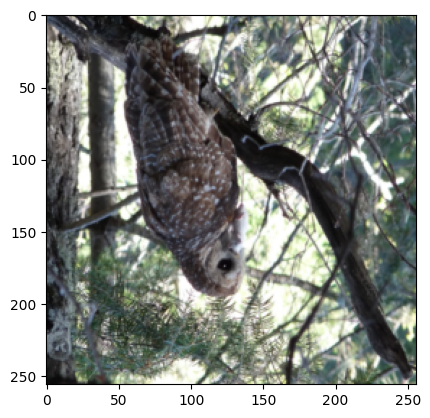

'Penguin'

In [24]:
selected_image, selected_label = train_dataset[11526]
selected_image = selected_image / 2 + 0.5     # denormalize
npimg = selected_image
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
train_classes[selected_label.item()]

# モデルの構築

In [25]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 21)

# GPUが使えるなら、GPUを使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader for train and test dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current sys

Epoch 1/10, Loss: 2.528254052367779
Epoch 2/10, Loss: 2.1752790461439604
Epoch 3/10, Loss: 1.9099440768771214
Epoch 4/10, Loss: 1.6888524498961388
Epoch 5/10, Loss: 1.4639739627958437
Epoch 6/10, Loss: 1.295236629220324
Epoch 7/10, Loss: 1.1634185733871723
Epoch 8/10, Loss: 1.0711894024402724
Epoch 9/10, Loss: 0.9703786654756703
Epoch 10/10, Loss: 0.8736144250275892


In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# モデルを評価モードに設定
model.eval()

# 予測と正解ラベルを保持するリスト
predictions = []
true_labels = []

# テストデータをバッチごとに処理
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # モデルの予測を計算
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # 予測と正解ラベルをリストに追加
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 評価指標を計算
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=selected_classes)
conf_mat = confusion_matrix(true_labels, predictions)

# 評価指標を表示
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_mat)


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy: 0.6442424242424243
Classification Report:
              precision    recall  f1-score   support

       train       0.47      0.90      0.62       170
        test       0.15      0.17      0.16        29

    accuracy                           0.64      3300
   macro avg       0.66      0.62      0.60      3300
weighted avg       0.72      0.64      0.65      3300

Confusion Matrix:
[[153   2   7   1   0   0   0   0   1   0   3   0   0   0   0   0   0   1
    2   0   0]
 [ 14   5   8   1   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  2   0 210   0   7   2   0   4  22   1   3   0   0   0   1   4   0   2
    0   1   1]
 [ 17   2  14 154   0   5   0   0   1   4   5   0   2   0   3   0   0   0
    0   0   0]
 [ 23   2  91   6 324   9   3   2  27  11   5   0  53   1   4  21   0  10
    6  18   1]
 [  4   0   6   2   1 268   1   1   0   0   0   3   0   1  12  18   0   0
    0   4   0]
 [  2   0   6   0   1   1 157   0   0   1   0   0   0   0   3   2   0